In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.recon_methods import multiPaganin
from holotomocupy.utils import *

np.random.seed(1)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 512  # object size in each dimension
z1c = -19.5e-3
code_thickness = 1.8e-6 #in m
ill_feature_size = 2e-6 #in m

npos = 49  # number of code positions
detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
z1 = np.tile(z1c, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size

# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = 1200+2*pad
show = True

flg = f'{n}_{1}_{npos}_{z1c}_0_code'
path = f'/data2/vnikitin/nfp_codes'
rho = 0.1

## Read data

In [3]:
data00 = np.zeros([1, npos, n, n], dtype='float32')
ref0 = np.zeros([1, npos, n, n], dtype='float32')
for k in range(npos):
    data00[:, k] = read_tiff(f'{path}/data/data_{k}_{flg}.tiff')[:1]
for k in range(npos):
    ref0[:, k] = read_tiff(f'{path}/data/ref_{k}_{flg}.tiff')[:]
code = np.load(f'{path}/data/code_{flg}.npy')
shifts = np.load(f'{path}/data/shifts_code_{flg}.npy')[:, :npos]

# Construct operators


In [4]:
def Lop(psi):
    psi = cp.array(psi)
    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()       
        psir = G(psir, wavelength, voxelsize, distances[i])
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def LTop(data):
    psi = cp.zeros([data.shape[0],npos, n+2*pad, n+2*pad], dtype='complex64')
    for j in range(npos):
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad))).astype('complex64')
        psir = GT(psir, wavelength, voxelsize, distances[j])        
        psi[:,j] = psir
    return psi

def Sop(psi,shifts):
    psi = cp.array(psi)
    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()    
        psir = S(psir, shifts[:, i])
        nee = psir.shape[1]        
        data[:,i] = psir[:, nee//2-n//2-pad:nee//2+n//2+pad, nee//2-n//2-pad:nee//2+n//2+pad]
    return data

def STop(data,shifts):
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:,j],((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))        
        psi += ST(psir,shifts[:,j])
    return psi

data = cp.array(data00)
arr1 = cp.pad(data[:,0],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')     
prb1 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
shifts = cp.array(shifts)
arr2 = Sop(arr1,shifts*rho)
arr3 = STop(arr2,shifts*rho)

arr4 = Lop(arr2)
arr5 = LTop(arr4)

print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')
print(f'{cp.sum(arr2*cp.conj(arr5))}==\n{cp.sum(arr4*cp.conj(arr4))}')

(24916900+1.8835697174072266j)==
(24916900+8.200871093322348e-09j)
(15695109-0.16330289840698242j)==
(15695109+1.0846337318071164e-05j)


#### Reconstruction with the CG (Carlsson) with Hessians

#### $$\nabla F=2 \left(L^*\left( L(M(q_0,\psi_0,\boldsymbol{x}_0))-\tilde D\right)\right).$$
#### where $$\tilde D = D \frac{L(M(q_0,\psi_0,\boldsymbol{x}_0))}{|L(M(q_0,\psi_0,\boldsymbol{x}_0))|}$$



In [5]:
def gradientF(psi,q,x,d):
    Lpsi = Lop(Sop(psi,x)*q)
    td = d*(Lpsi/cp.abs(Lpsi))
    res = 2*LTop(Lpsi - td)
    return res

#### $$\frac{1}{2}\mathcal{H}|_{x_0}(y,z)= \left\langle \mathbf{1}-d_{0}, \mathsf{Re}({L(y)}\overline{L(z)})\right\rangle+\left\langle d_{0},(\mathsf{Re} (\overline{l_0}\cdot L(y)))\cdot (\mathsf{Re} (\overline{l_0}\cdot L(z)))\right\rangle.$$
#### $$l_0=L(x_0)/|L(x_0)|$$
#### $$d_0=d/|L(x_0)|$$


In [6]:
def hessianF(hpsi,hpsi1,hpsi2,data):
    Lpsi = Lop(hpsi)        
    Lpsi1 = Lop(hpsi1)
    Lpsi2 = Lop(hpsi2)    
    l0 = Lpsi/cp.abs(Lpsi)
    d0 = data/cp.abs(Lpsi)
    v1 = cp.sum((1-d0)*cp.real(Lpsi1*cp.conj(Lpsi2)))
    v2 = cp.sum(d0*
        cp.real(cp.conj(l0)*Lpsi1)*
        cp.real(cp.conj(l0)*Lpsi2))
    return 2*(v1+v2)

##### $$\nabla_{\psi} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=S_{\boldsymbol{x}_{0}}^*\left(\overline{J(q_0)}\cdot \nabla F\right).$$
##### $$\nabla_{q} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=J^*\left( \overline{S_{\boldsymbol{x}_{0}}(\psi_0)}\cdot \nabla F\right).$$
##### $$\nabla_{\boldsymbol{x}_0} G|_{(q_0,\psi_0,\boldsymbol{x}_0)}=\textsf{Re}\Big(\big( \Big\langle \overline{q_0}\cdot \nabla F,   C(\mathcal{F}^{-1}(-2\pi i \xi_1 e^{ -2\pi i \boldsymbol{x}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0}))\Big\rangle,\Big\langle \overline{q_0}\cdot \nabla F,C(\mathcal{F}^{-1}(-2\pi i \xi_2 e^{ -2\pi i \boldsymbol{x}_{0,k}\cdot \boldsymbol{\xi}}\hat{\psi_0})) \Big\rangle\big)\Big)_{k=1}^K. $$

#### new operator $$T_{\psi,w}(x) = C(\mathcal{F}^{-1}(w e^{-2\pi i \boldsymbol{x}_{0}\cdot \boldsymbol{\xi}}\hat{\psi_0}))$$




In [7]:
def Twop(psi,x,w):
    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    xi1 = cp.fft.fftfreq(2*ne).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    for i in range(npos):
        psir = psi.copy()            
        p = x[:,i]
        psir = cp.pad(psir, ((0, 0), (ne//2, ne//2), (ne//2, ne//2)), 'constant')
        pp = w*cp.exp(-2*cp.pi*1j*(xi1*p[:, 0, None, None]+xi2*p[:, 1, None, None]))    
        psir = cp.fft.ifft2(pp*cp.fft.fft2(psir))   
        data[:,i] = psir[:, ne-n//2-pad:ne+n//2+pad, ne-n//2-pad:ne+n//2+pad]        
    return data

def gradientx(psi,q,x,gradF):
    xi1 = cp.fft.fftfreq(2*psi.shape[-1]).astype('float32')    
    [xi2, xi1] = cp.meshgrid(xi1, xi1)  
    tksi1 = Twop(psi,x,-2*cp.pi*1j*xi1)
    tksi2 = Twop(psi,x,-2*cp.pi*1j*xi2)
    gradx = cp.zeros([1,npos,2],dtype='float32')
    gradx[:,:,0] = cp.sum(cp.real(cp.conj(q)*gradF*cp.conj(tksi1)),axis=(2,3))
    gradx[:,:,1] = cp.sum(cp.real(cp.conj(q)*gradF*cp.conj(tksi2)),axis=(2,3))
    return gradx

def gradients(psi,q,x,d):
    gradF = gradientF(psi,q,x,d)
    gradpsi = STop(cp.conj(q)*gradF,x)
    gradq = cp.sum(cp.conj(Sop(psi,x))*gradF,axis=1)
    gradx = rho*gradientx(psi,q,x,gradF)
    return gradpsi,gradq,gradx

#### $$ D T_\psi|_{{\boldsymbol{z}_0}}(\Delta \boldsymbol{z})=C(\mathcal{F}^{-1}(-2\pi i\xi_1 e^{ -2\pi i\boldsymbol{z}_0\cdot \boldsymbol{\xi}}\hat{\psi}))\Delta {z}_{1}+C(\mathcal{F}^{-1}(-2\pi i\xi_2 e^{-2\pi i \boldsymbol{z}_0\cdot \boldsymbol{\xi}}\hat{\psi}))\Delta {z}_2$$

In [8]:
def DT(psi,x,dx):
    xi1 = cp.fft.fftfreq(2*psi.shape[-1]).astype('float32')
    [xi2, xi1] = cp.meshgrid(xi1, xi1)
    tksi1 = Twop(psi,x,-2*cp.pi*1j*xi1)
    tksi2 = Twop(psi,x,-2*cp.pi*1j*xi2)
    res = tksi1*dx[:,:,0,None,None]+tksi2*dx[:,:,1,None,None]
    return res

#### $$D^2{T_\psi}|_{{\boldsymbol{z}_0}}(\Delta\boldsymbol{z},\Delta\boldsymbol{w})=$$
#### $$\Delta {z}_{1}\Delta {w}_{1} C(\mathcal{F}^{-1}(-4\pi^2 \xi_1^2 e^{ -2\pi i\boldsymbol{z}_0\cdot \boldsymbol{\xi}}\hat{\psi})) +(\Delta {z}_{1}\Delta {w}_{2} +$$
#### $$ \Delta {w}_{1}\Delta {z}_{2})C(\mathcal{F}^{-1}(-4\pi^2 \xi_1\xi_2 e^{ -2\pi i\boldsymbol{z}_0\cdot \boldsymbol{\xi}}\hat{\psi}))+\Delta {z}_{2}\Delta {w}_{2} C(\mathcal{F}^{-1}(-4\pi^2\xi_2^2 e^{ -2\pi i\boldsymbol{z}_0\cdot \boldsymbol{\xi}}\hat{\psi}))$$

In [9]:
def D2T(psi,x,dx1,dx2):
    xi1 = cp.fft.fftfreq(2*psi.shape[-1]).astype('float32')
    [xi2,xi1] = cp.meshgrid(xi1, xi1)
    dx11 = dx1[:,:,:,None,None] 
    dx22 = dx2[:,:,:,None,None] 
    res = dx11[:,:,0]*dx22[:,:,0]*Twop(psi,x,-4*cp.pi**2*xi1**2)+ \
         (dx11[:,:,0]*dx22[:,:,1]+dx11[:,:,1]*dx22[:,:,0])*Twop(psi,x,-4*cp.pi**2*xi1*xi2)+ \
          dx11[:,:,1]*dx22[:,:,1]*Twop(psi,x,-4*cp.pi**2*xi2**2)
    return res

#### $$ DM|_{(q_0,\psi_0,\boldsymbol{x})}(\Delta q, \Delta \psi,\Delta\boldsymbol{x})=$$
#### $$ \Big(\Delta q\cdot T_{\psi_0}({\boldsymbol{x}_{0,k}})+ q_0\cdot \big(T_{\Delta \psi}({\boldsymbol{x}_{0,k}})+  DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}_k)\big) \Big)_{k=1}^K=$$
#### $$ J(\Delta q)\cdot S_{\boldsymbol{x}_{0,k}}(\psi_0)+ J(q_0)\cdot S_{\boldsymbol{x}_{0}}{(\Delta \psi)}+  \Big(q_0\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}_k) \Big)_{k=1}^K$$


In [10]:
def DM(psi,q,x,dpsi,dq,dx):
    res = dq*Sop(psi,x)+q*(Sop(dpsi,x)+rho*DT(psi,x,dx))   
    return res

##### $$ D^2M|_{(q_0,\psi_0,\boldsymbol{x})}\big((\Delta q^{(1)}, \Delta \psi^{(1)},\Delta\boldsymbol{x}^{(1)}),(\Delta q^{(2)}, \Delta \psi^{(2)},\Delta\boldsymbol{x}^{(2)})\big)= $$
##### $$\Big( q_0\cdot DT_{\Delta\psi^{(1)}}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(2)})+q_0\cdot DT_{\Delta\psi^{(2)}}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(1)})+ q_0\cdot D^2{T_\psi}|_{{\boldsymbol{x}_0}}(\Delta\boldsymbol{x}^{(1)},\Delta\boldsymbol{x}^{(2)})+$$
##### $$\Delta q^{(1)}\cdot T_{\Delta \psi^{(2)}}({\boldsymbol{x}_{0,k}})+\Delta q^{(2)}\cdot T_{\Delta \psi^{(1)}}({\boldsymbol{x}_{0,k}})+ $$
##### $$\Delta q^{(1)}\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(2)})+\Delta q^{(2)}\cdot DT_{\psi_0}|_{{\boldsymbol{x}_{0,k}}}( \Delta \boldsymbol{x}^{(1)})\Big)_{k=1}^K.$$


In [11]:
def D2M(psi,q,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2):    
    res =  q*rho*DT(dpsi1,x,dx2) + q*rho*DT(dpsi2,x,dx1) + q*rho**2*D2T(psi,x,dx1,dx2)  
    res += dq1*Sop(dpsi2,x) + dq2*Sop(dpsi1,x) 
    res += dq1*rho*DT(psi,x,dx2) + dq2*rho*DT(psi,x,dx1)
    return res

##### $$\mathcal{H}^G|_{ (q_0,\psi_0,\boldsymbol{x}_0)}\Big((\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)=$$
##### $$\Big\langle \nabla F|_{M(q_0,\psi_0,\boldsymbol{x}_0)}, D^2M|_{(q_0,\psi_0,\boldsymbol{x}_0)}\Big((\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big)\Big\rangle +$$
##### $$\mathcal{H}^F|_{M(q_0,\psi_0,\boldsymbol{x}_0)}\Big(DM|_{(q_0,\psi_0,\boldsymbol{x}_0)}(\Delta q^{(1)},\Delta \psi^{(1)},\Delta \boldsymbol{x}^{(1)}),DM|_{(q_0,\psi_0,\boldsymbol{x}_0)}(\Delta q^{(2)},\Delta \psi^{(2)},\Delta \boldsymbol{x}^{(2)})\Big).$$

In [12]:
def hessian2(psi,q,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2,data):
    gradF = gradientF(psi,q,x,data)
    res = cp.sum(cp.real(gradF*cp.conj(D2M(psi,q,x,dpsi1,dq1,dx1,dpsi2,dq2,dx2))))
    res += hessianF(Sop(psi,x)*q, DM(psi,q,x,dpsi1,dq1,dx1), DM(psi,q,x,dpsi2,dq2,dx2),data)         
    return res

In [13]:
def rec_init(ref0,data00,shifts):
    ref0 = cp.array(ref0)
    data00 = cp.array(data00)

    rdata = data00/ref0
    # mshow((rdata)[0,0],show,vmax=2)
    recMultiPaganin = cp.zeros([1,npos,ne,ne],dtype='float32')
    recMultiPaganinr = cp.zeros([1,npos,ne,ne],dtype='float32')# to compensate for overlap
    for j in range(0,npos):
        r = multiPaganin(rdata[:,j:j+1],
                            distances[j:j+1], wavelength, voxelsize,  24.05, 5e-2)    
        rr = r*0+1 # to compensate for overlap
        r = cp.pad(r,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
        rr = cp.pad(rr,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
        recMultiPaganin[:,j] = ST(r,shifts[:,j])
        recMultiPaganinr[:,j] = ST(rr,shifts[:,j])
        
    recMultiPaganin = cp.sum(recMultiPaganin,axis=1)
    recMultiPaganinr = cp.sum(recMultiPaganinr,axis=1)

    # avoid division by 0
    recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1

    # compensate for overlap
    recMultiPaganin /= recMultiPaganinr
    recMultiPaganin = cp.exp(1j*recMultiPaganin)

    # mshow_polar(recMultiPaganin[0],show)
    # mshow_polar(recMultiPaganin[0,pad:-pad,pad:-pad],show)
    return recMultiPaganin


In [14]:
def minf(fpsi,data):
    f = np.linalg.norm(np.abs(fpsi)-data)**2
    return f

def plot_debug2(psi,prb,shifts,etapsi,etaprb,etashift,top,bottom,gammah,data):
    npp = 17
    errt = np.zeros(npp*2)
    errt2 = np.zeros(npp*2)
    for k in range(0,npp*2):
        psit = psi+(gammah*k/(npp-1))*etapsi
        prbt = prb+(gammah*k/(npp-1))*etaprb
        shiftst = shifts+(gammah*k/(npp-1))*etashift
        fpsit = Lop(Sop(psit,shiftst*rho)*prbt)
        errt[k] = minf(fpsit,data)    

    t = gammah*(cp.arange(2*npp))/(npp-1)
    errt2 = minf(Lop(Sop(psi,shifts*rho)*prb),data)-top*t+0.5*bottom*t**2
    
    plt.plot(gammah.get()*np.arange(2*npp)/(npp-1),errt,'.')
    plt.plot(gammah.get()*np.arange(2*npp)/(npp-1),errt2.get(),'.')
    plt.show()

def plot_debug3(shifts):
    plt.plot((shifts_gt[0,:,0]).get()-(shifts[0,:,0]).get(),'r.')
    plt.plot((shifts_gt[0,:,1]).get()-(shifts[0,:,1]).get(),'b.')
    plt.show()

/tmp/ipykernel_1773556/3191795650.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganin[:,j] = ST(r,shifts[:,j])
/tmp/ipykernel_1773556/3191795650.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganinr[:,j] = ST(rr,shifts[:,j])


ITERATION 0
gradient norms (psi, prb, shift): 1813.33, 9017.91, 707.16


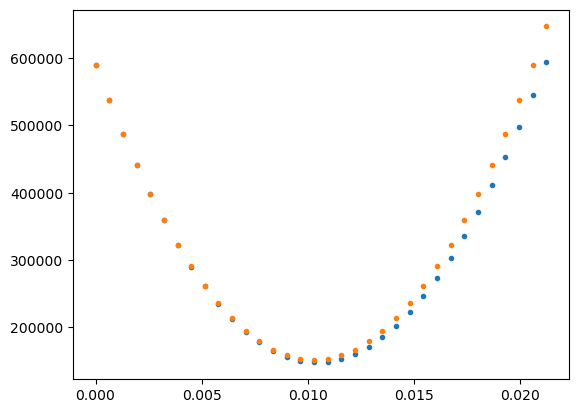

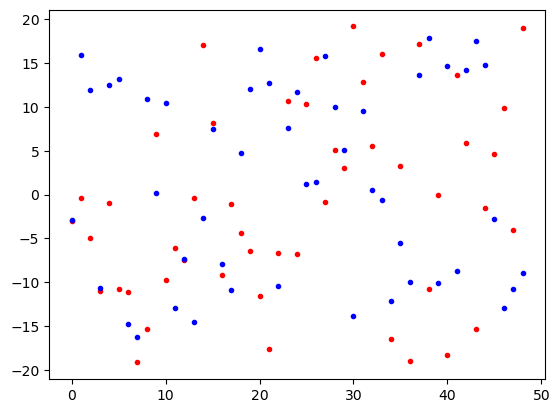

0) gammah=array(0.01030676, dtype=float32), err=1.47995e+05

ITERATION 1
gradient norms (psi, prb, shift): 820.63, 688.67, 731.31


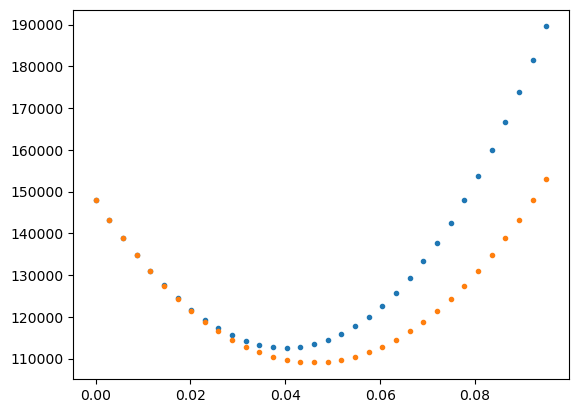

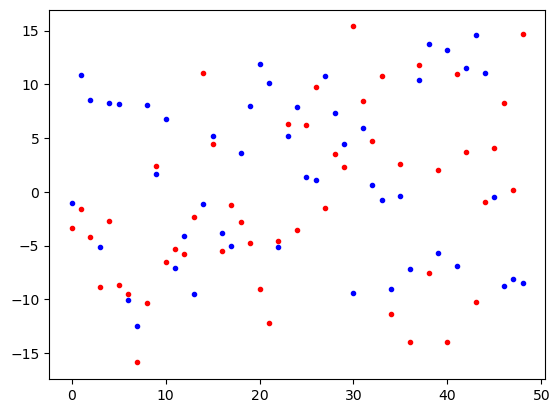

1) gammah=array(0.04608819, dtype=float32), err=1.13437e+05

ITERATION 2
gradient norms (psi, prb, shift): 917.20, 1811.37, 654.47


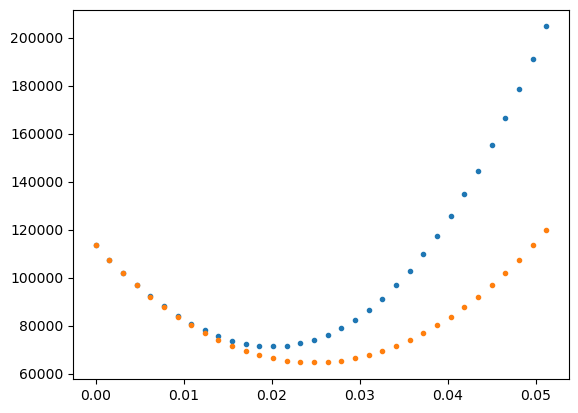

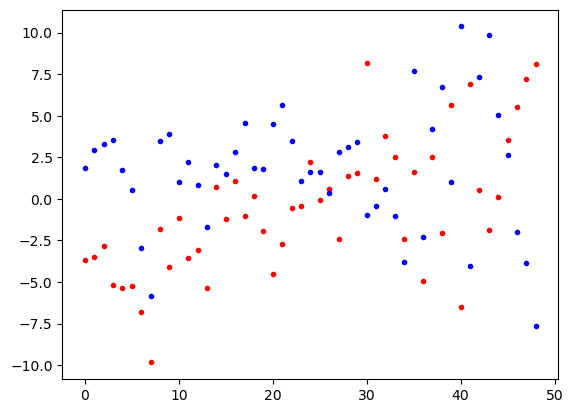

2) gammah=array(0.02482182, dtype=float32), err=7.40833e+04

ITERATION 3
gradient norms (psi, prb, shift): 1279.48, 757.69, 539.71


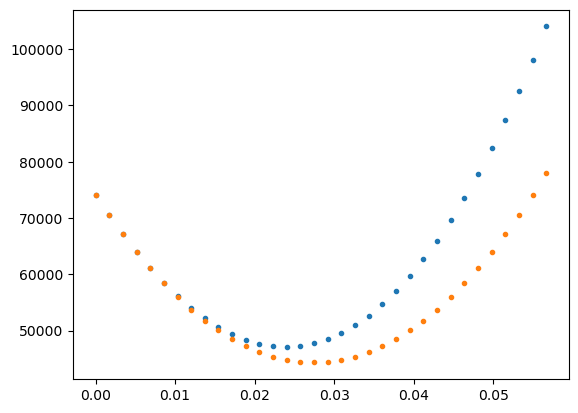

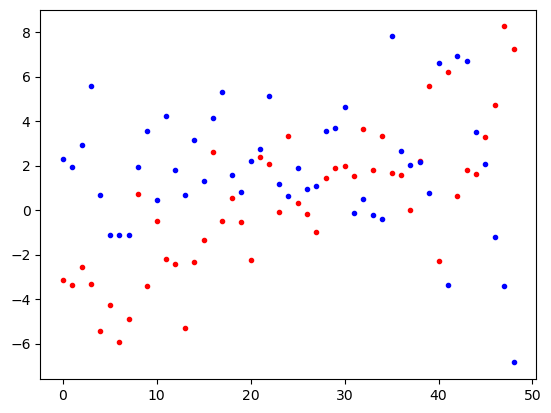

3) gammah=array(0.0274814, dtype=float32), err=4.77182e+04

ITERATION 4
gradient norms (psi, prb, shift): 767.66, 1131.15, 525.86


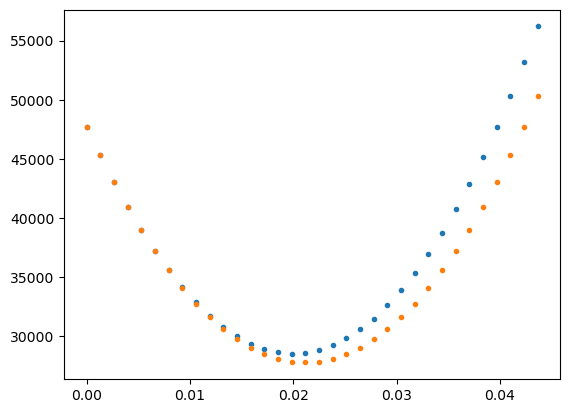

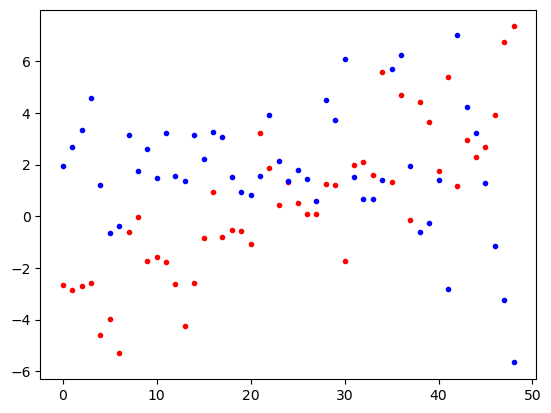

4) gammah=array(0.02116468, dtype=float32), err=2.86001e+04

ITERATION 5
gradient norms (psi, prb, shift): 509.91, 382.07, 501.54


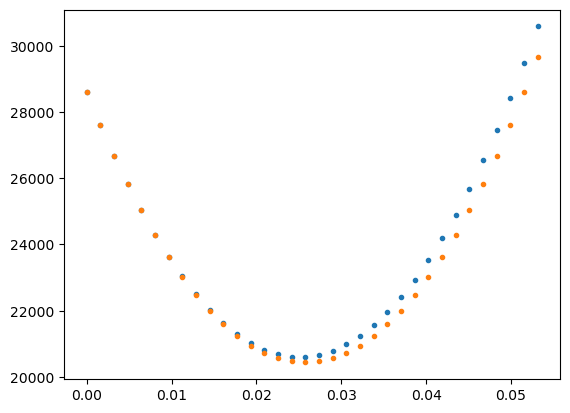

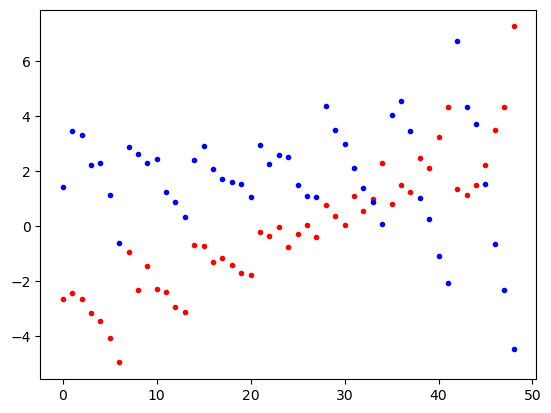

5) gammah=array(0.02575741, dtype=float32), err=2.05988e+04

ITERATION 6
gradient norms (psi, prb, shift): 355.34, 462.88, 164.23


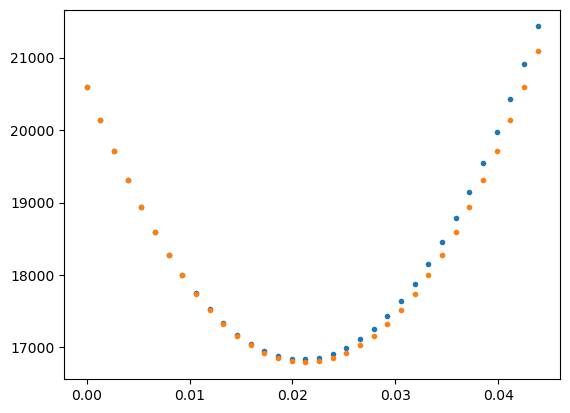

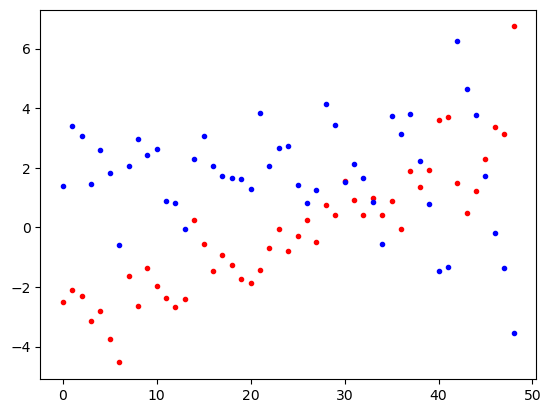

6) gammah=array(0.02124708, dtype=float32), err=1.68339e+04

ITERATION 7
gradient norms (psi, prb, shift): 263.36, 258.11, 226.85


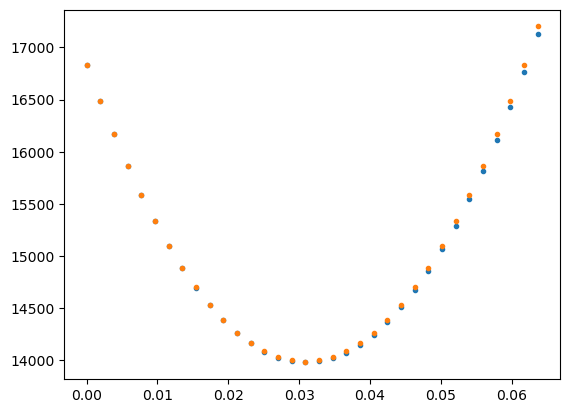

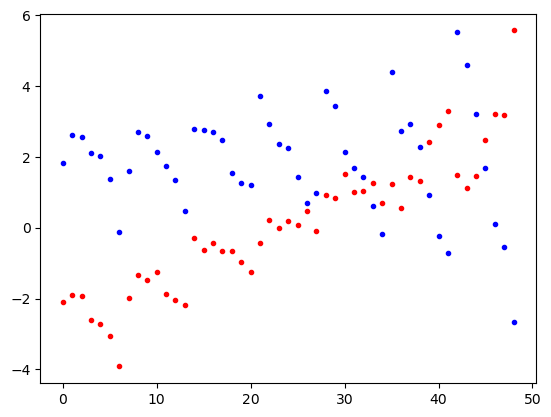

7) gammah=array(0.03086138, dtype=float32), err=1.39783e+04

ITERATION 8
gradient norms (psi, prb, shift): 236.02, 275.81, 135.35


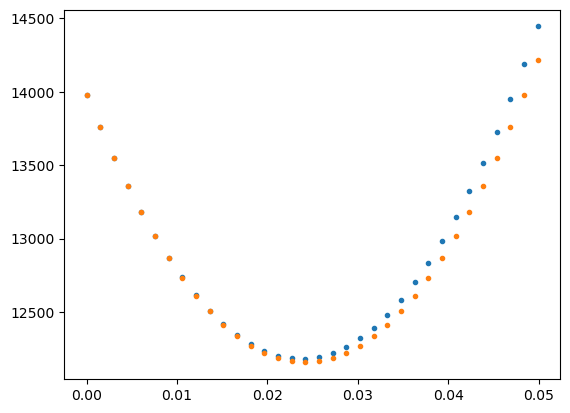

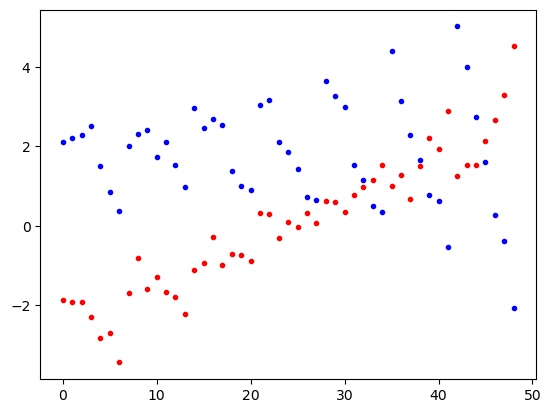

8) gammah=array(0.02418643, dtype=float32), err=1.21822e+04

ITERATION 9
gradient norms (psi, prb, shift): 214.42, 218.17, 128.30


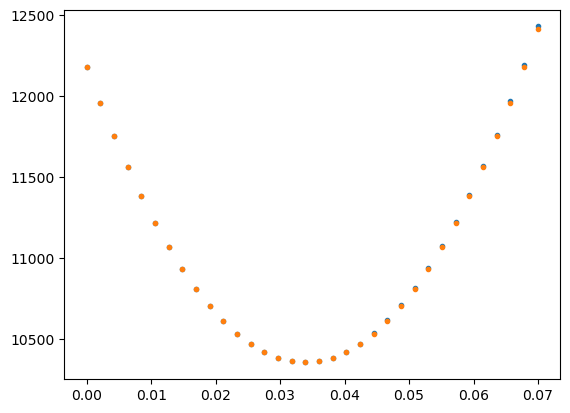

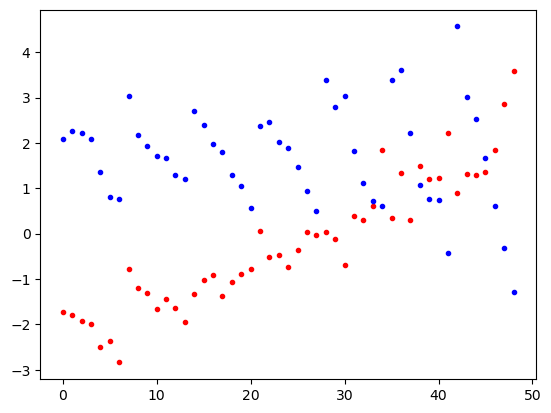

9) gammah=array(0.03389991, dtype=float32), err=1.03585e+04

ITERATION 10
gradient norms (psi, prb, shift): 180.42, 186.88, 165.35


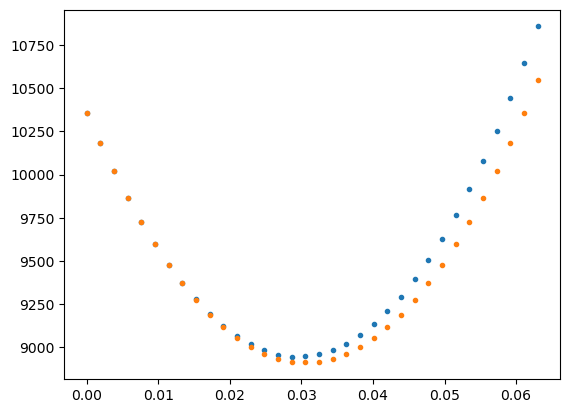

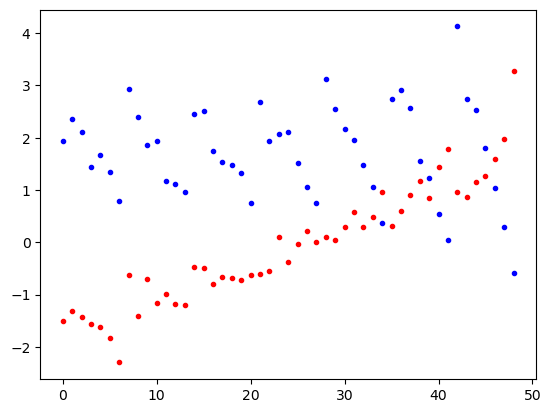

10) gammah=array(0.03054265, dtype=float32), err=8.94700e+03

ITERATION 11
gradient norms (psi, prb, shift): 175.46, 203.41, 85.43


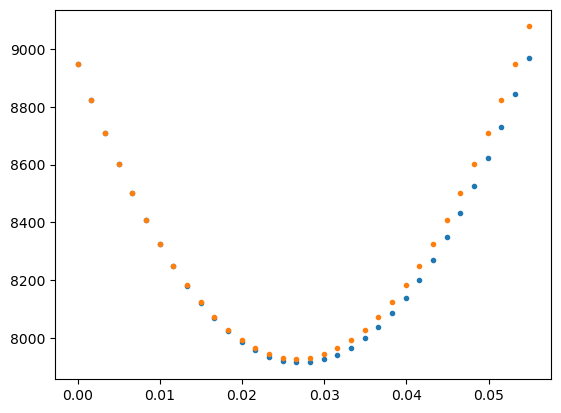

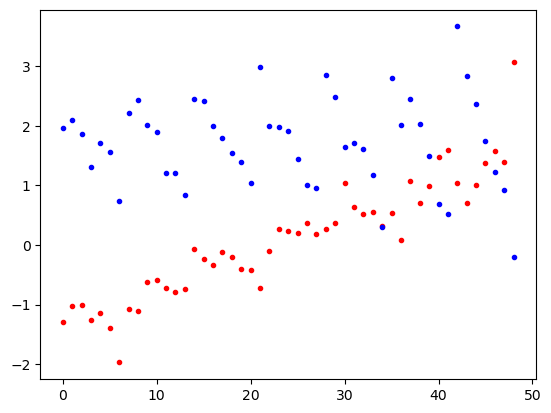

11) gammah=array(0.0266046, dtype=float32), err=7.91485e+03

ITERATION 12
gradient norms (psi, prb, shift): 164.91, 150.84, 123.99


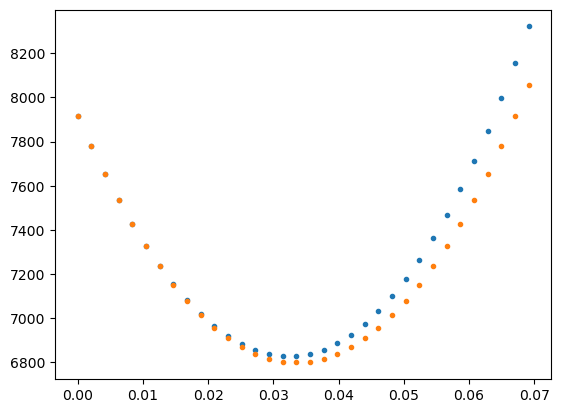

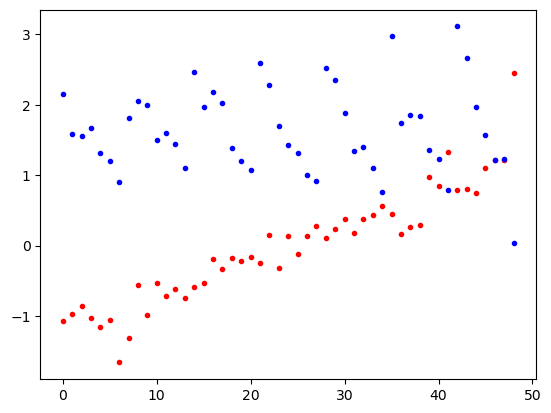

12) gammah=array(0.03353326, dtype=float32), err=6.82866e+03

ITERATION 13
gradient norms (psi, prb, shift): 138.47, 188.53, 85.14


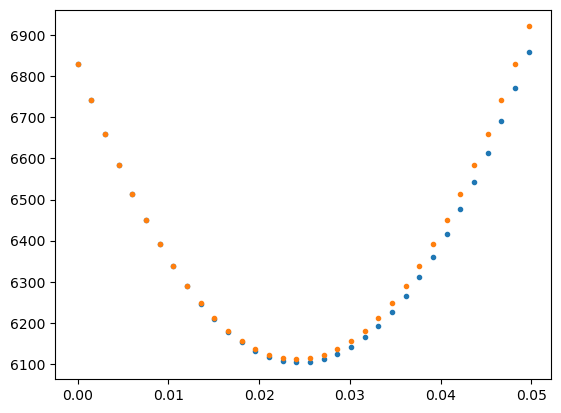

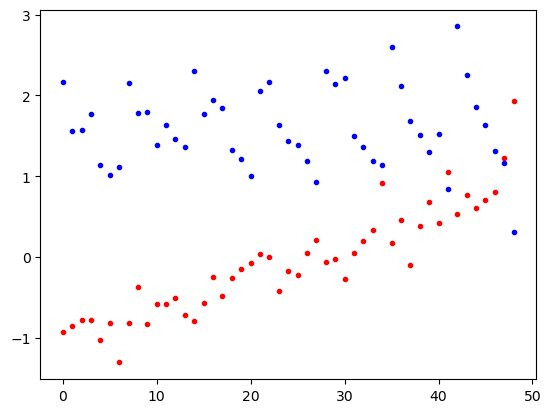

13) gammah=array(0.02410121, dtype=float32), err=6.10351e+03

ITERATION 14
gradient norms (psi, prb, shift): 135.00, 113.25, 89.28


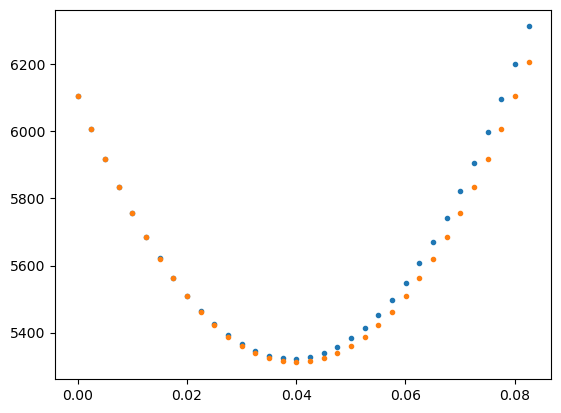

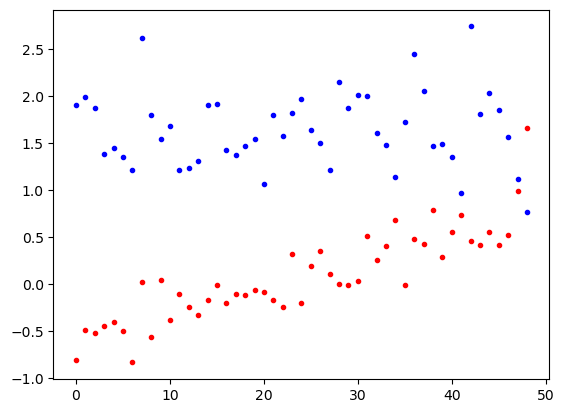

14) gammah=array(0.04004266, dtype=float32), err=5.32262e+03

ITERATION 15
gradient norms (psi, prb, shift): 107.25, 128.12, 93.48


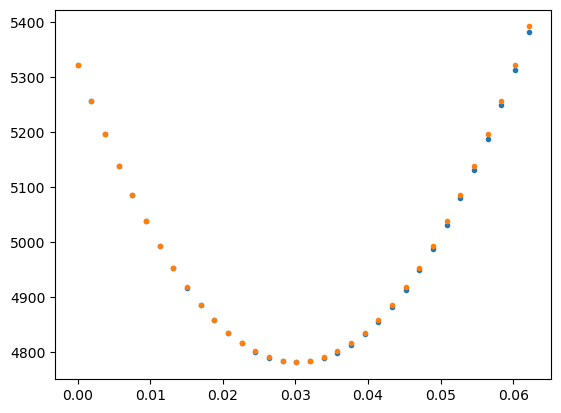

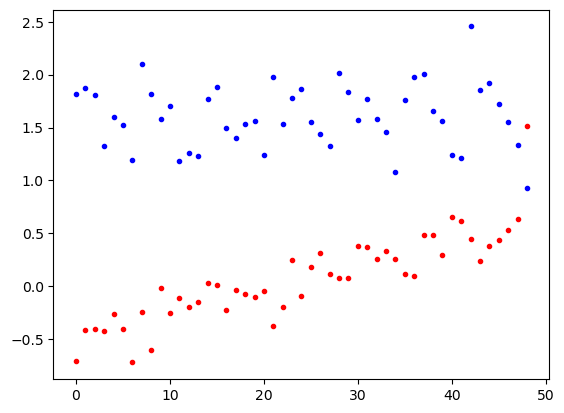

15) gammah=array(0.03012826, dtype=float32), err=4.78123e+03

ITERATION 16
gradient norms (psi, prb, shift): 104.66, 127.43, 65.50


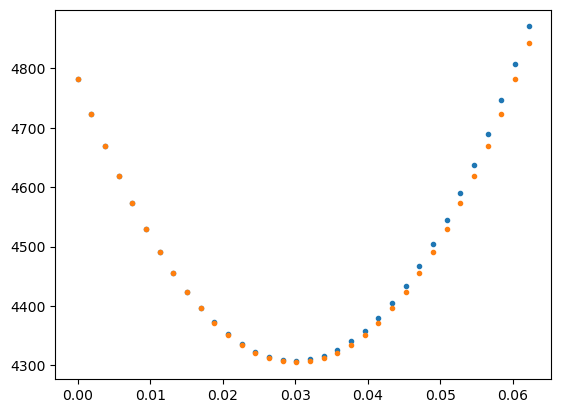

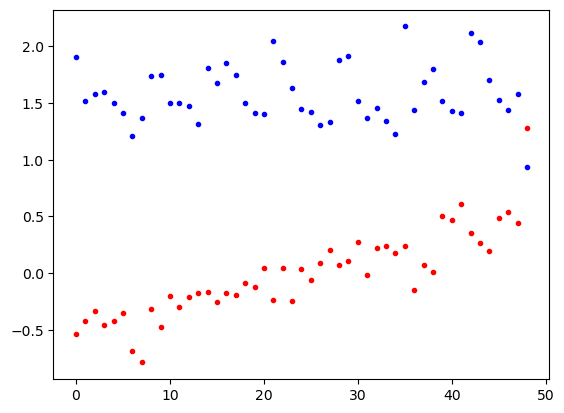

16) gammah=array(0.03015975, dtype=float32), err=4.30775e+03

ITERATION 17
gradient norms (psi, prb, shift): 98.95, 100.65, 70.84


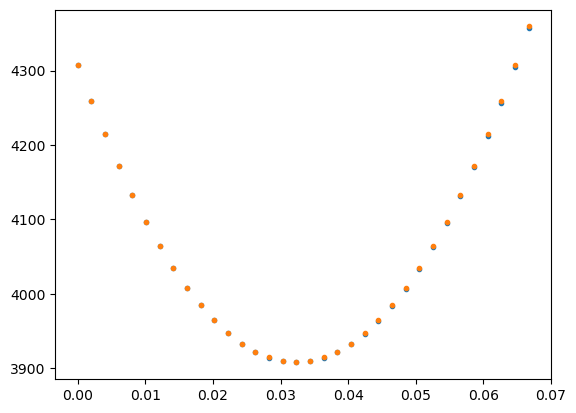

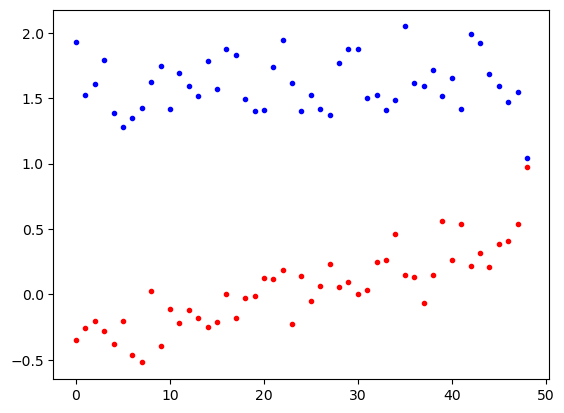

17) gammah=array(0.03234184, dtype=float32), err=3.90779e+03

ITERATION 18
gradient norms (psi, prb, shift): 86.28, 123.14, 59.84


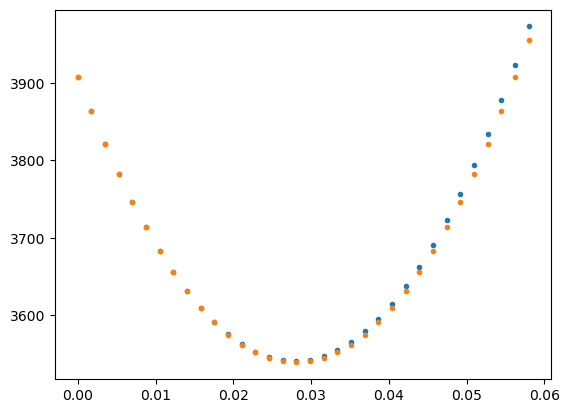

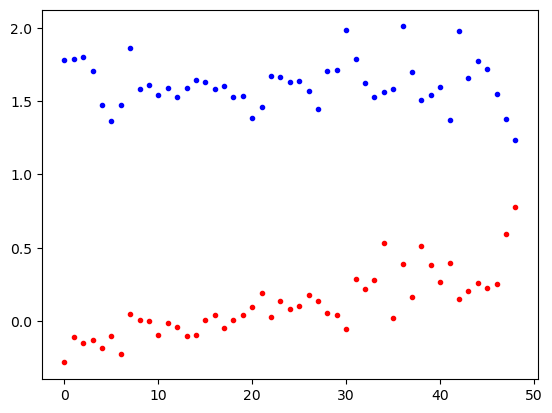

18) gammah=array(0.02811179, dtype=float32), err=3.54087e+03

ITERATION 19
gradient norms (psi, prb, shift): 87.38, 81.15, 56.37


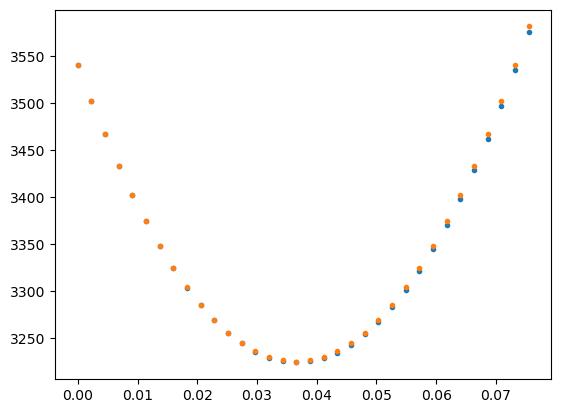

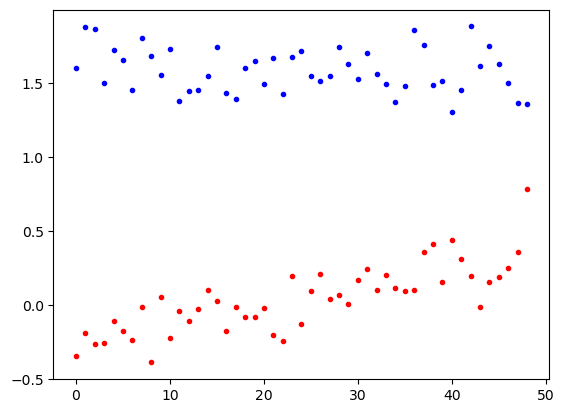

19) gammah=array(0.03659347, dtype=float32), err=3.22405e+03

ITERATION 20
gradient norms (psi, prb, shift): 75.95, 103.69, 53.17


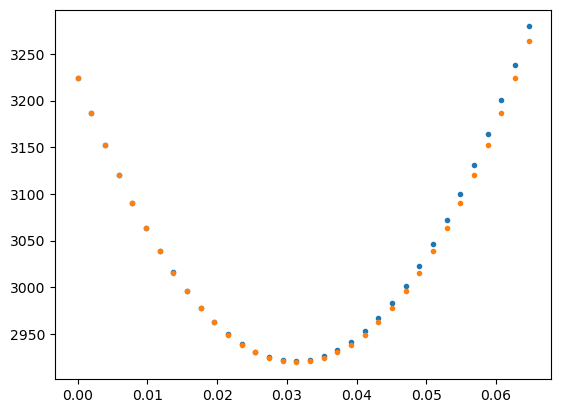

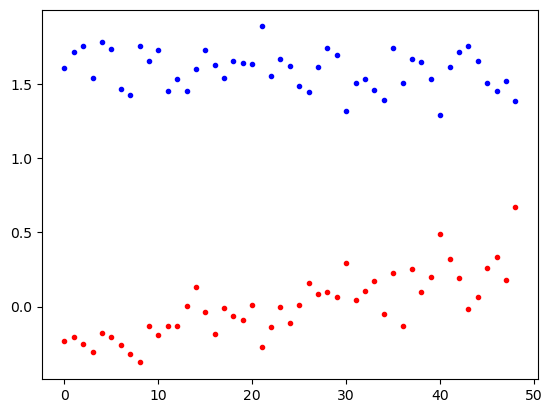

20) gammah=array(0.03135569, dtype=float32), err=2.92110e+03

ITERATION 21
gradient norms (psi, prb, shift): 76.38, 82.41, 55.98


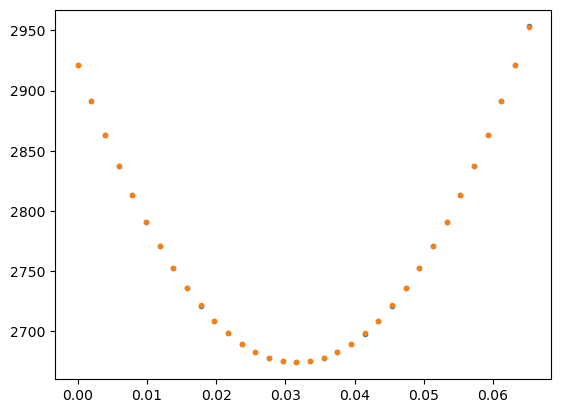

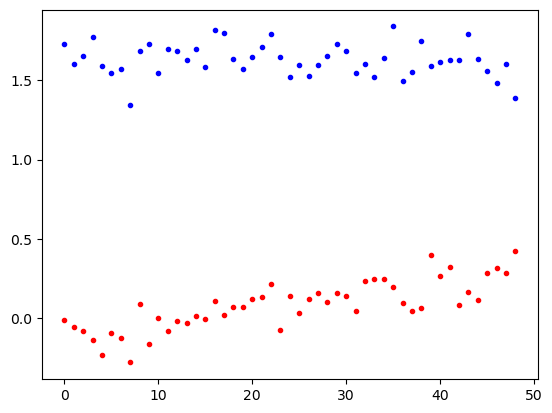

21) gammah=array(0.0315934, dtype=float32), err=2.67408e+03

ITERATION 22
gradient norms (psi, prb, shift): 73.31, 81.16, 44.45


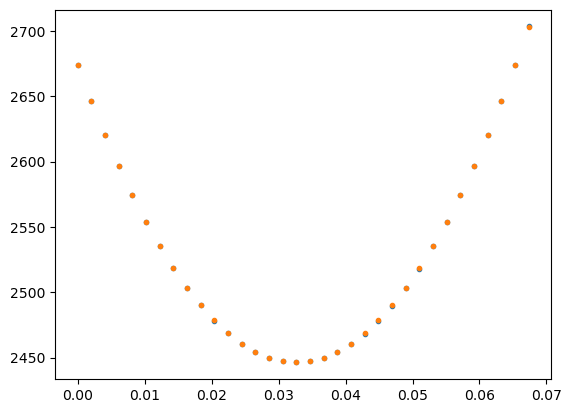

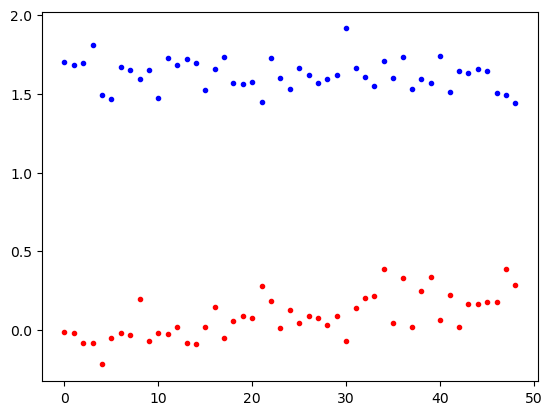

22) gammah=array(0.03265226, dtype=float32), err=2.44630e+03

ITERATION 23
gradient norms (psi, prb, shift): 66.06, 83.49, 50.80


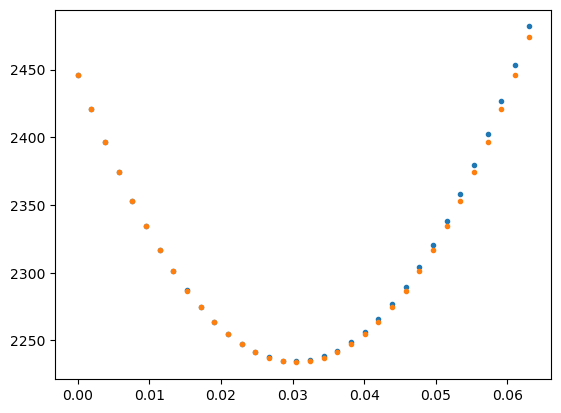

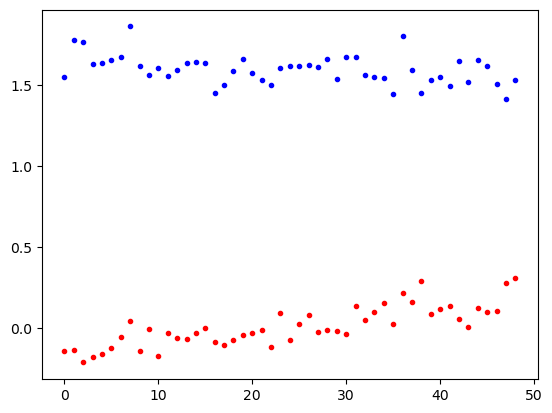

23) gammah=array(0.03053387, dtype=float32), err=2.23449e+03

ITERATION 24
gradient norms (psi, prb, shift): 65.93, 68.41, 40.85


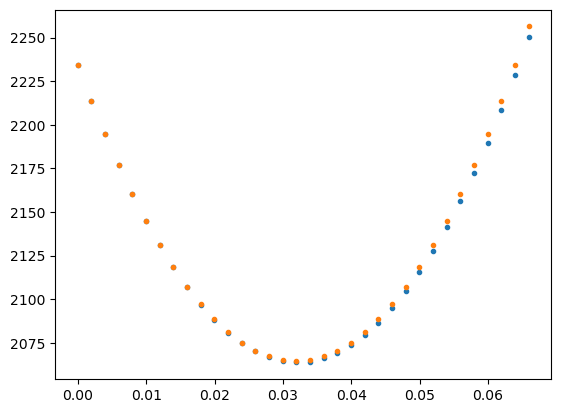

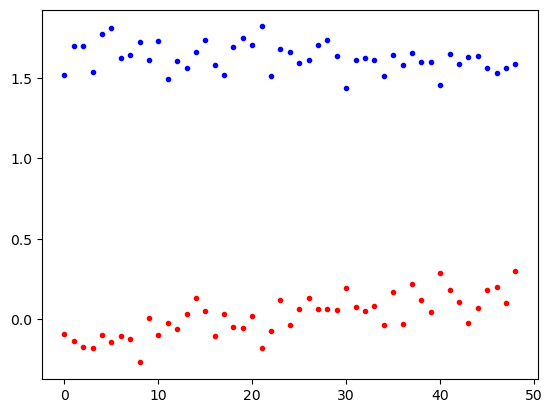

24) gammah=array(0.03197675, dtype=float32), err=2.06367e+03

ITERATION 25
gradient norms (psi, prb, shift): 59.88, 74.30, 38.11


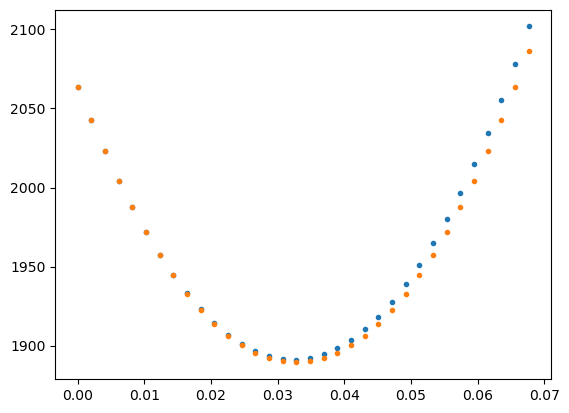

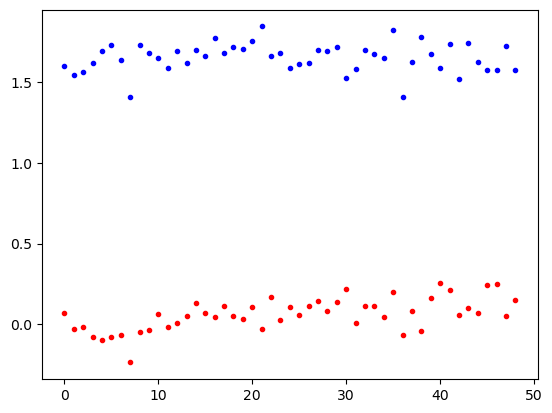

25) gammah=array(0.03279478, dtype=float32), err=1.89101e+03

ITERATION 26
gradient norms (psi, prb, shift): 58.12, 65.65, 43.52


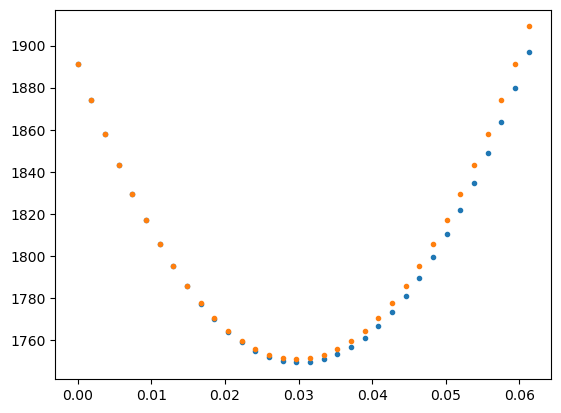

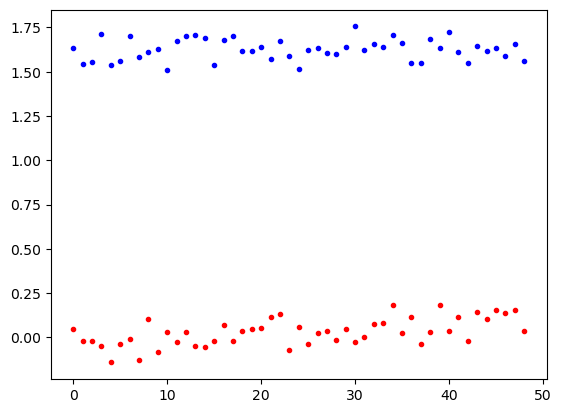

26) gammah=array(0.02969983, dtype=float32), err=1.74932e+03

ITERATION 27
gradient norms (psi, prb, shift): 56.79, 63.44, 29.43


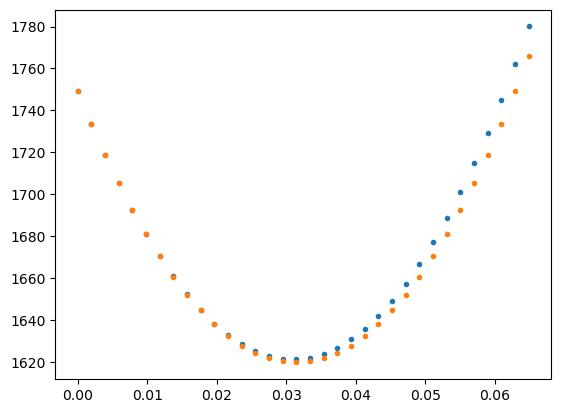

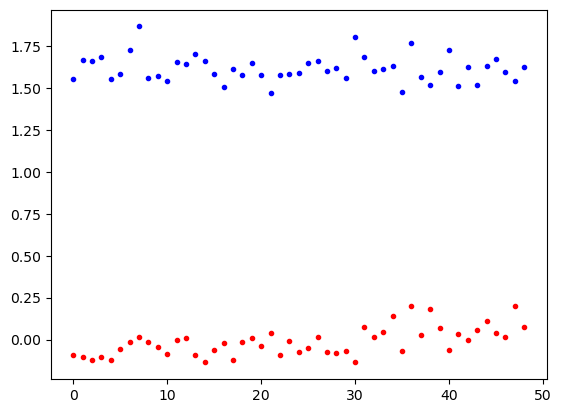

27) gammah=array(0.03145797, dtype=float32), err=1.62123e+03

ITERATION 28
gradient norms (psi, prb, shift): 53.25, 63.78, 39.17


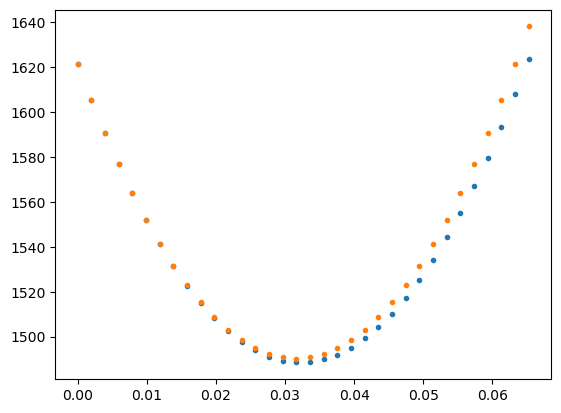

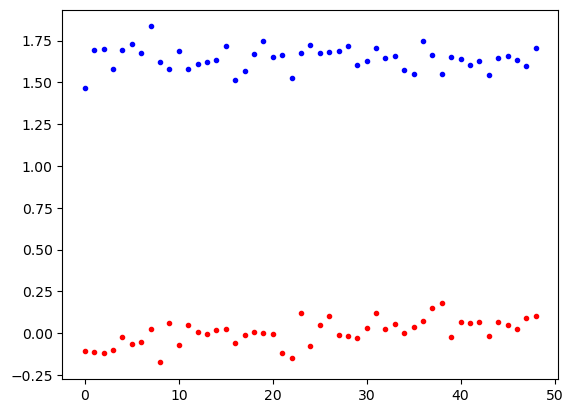

28) gammah=array(0.03162998, dtype=float32), err=1.48849e+03

ITERATION 29
gradient norms (psi, prb, shift): 50.86, 57.07, 31.87


In [15]:
def cg_holo(data, psi, prb,init_shifts, pars):

    data = np.sqrt(data)    
    shifts = init_shifts.copy()

    conv = np.zeros(pars['niter'])
    gammaha = np.zeros(pars['niter'])    
    
    for i in range(pars['niter']):                                                
        print(f"ITERATION {i}")        
        
        gradpsi, gradprb, gradshift = gradients(psi,prb,shifts*rho,data)
        print(f'gradient norms (psi, prb, shift): {cp.linalg.norm(gradpsi):.2f}, {cp.linalg.norm(gradprb):.2f}, {cp.linalg.norm(gradshift):.2f}')                        

        if i==0:
            etapsi = -gradpsi
            etaprb = -gradprb
            etashift = -gradshift
        else:      
            beta = hessian2(psi,prb,shifts*rho,gradpsi,gradprb,gradshift,etapsi,etaprb,etashift,data)/\
                   hessian2(psi,prb,shifts*rho, etapsi, etaprb, etashift,etapsi,etaprb,etashift,data)                        
            etapsi = -gradpsi + beta*etapsi
            etaprb = -gradprb + beta*etaprb
            etashift = -gradshift + beta*etashift            
        
        top = -(cp.sum(cp.real(gradpsi*cp.conj(etapsi)))+
                cp.sum(cp.real(gradprb*cp.conj(etaprb)))+
                cp.sum(cp.real(gradshift*cp.conj(etashift))))        
        bottom = hessian2(psi,prb,shifts*rho,etapsi,etaprb,etashift,
                                         etapsi,etaprb,etashift,data)
        gammah = top/bottom        
        
        plot_debug2(psi,prb,shifts,etapsi,etaprb,etashift,top,bottom,gammah,data)
        
        psi += gammah*etapsi
        prb += gammah*etaprb
        shifts += gammah*etashift
        
        plot_debug3(shifts)

        if i % pars['err_step'] == 0:
            fpsi = Lop(Sop(psi,shifts*rho)*prb)
            err = minf(fpsi,data)
            conv[i] = err
            gammaha[i] = gammah
            print(f'{i}) {gammah=}, {err=:1.5e}\n')
        
    return conv,gammaha

rec_psi = cp.ones([1,ne,ne],dtype='complex64')
data = cp.array(data00.copy())
rec_shifts = cp.array(shifts/rho)
shifts_gt = cp.array(shifts/rho)
rec_shifts += 4*(cp.random.random(rec_shifts.shape)-0.5)/rho

rec_psi = rec_init(ref0,data00,rec_shifts*rho)
rec_prb = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
pars = {'niter': 257, 'err_step': 1, 'vis_step': -1}

# rec_prb = cp.array(np.load(f'{path}/data/prb_{flg}.npy'))
# rec_psi = cp.array(np.load(f'{path}/data/psi_{flg}.npy'))
rec_psi = rec_psi[:,rec_psi.shape[1]//2-ne//2:rec_psi.shape[1]//2+ne//2,rec_psi.shape[2]//2-ne//2:rec_psi.shape[2]//2+ne//2]

conv,gammaha = cg_holo(data,rec_psi,rec_prb,rec_shifts, pars)   